# PIMA Diabetes Prediction with Neural Networks

First we imports the necessary libraries and loads the PIMA diabetes dataset. We separate the features and labels and then standardize the data. Standardization helps speed up the convergence of the neural network and improve model performance.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import roc_auc_score


In [3]:
random.seed(71)
np.random.seed(71)

In [4]:
names = ['times_pregnant', 'glucose_tolerance_test', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi', 'pedigree_function', 'age', 'has_diabetes']
diabetes = pd.read_csv('diabetes.csv', names = names, header = 0)
X = diabetes.drop("has_diabetes", axis=1).values
y = diabetes["has_diabetes"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 71)
normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

Then, we define a neural network model with two hidden layers, each containing 12 units, using the `relu` activation function. We apply L2 regularization to prevent overfitting. The output layer uses the `sigmoid` activation function for binary classification.

In [5]:
model = Sequential()
model.add(Dense(12, input_shape=(8,), activation="relu", 
                kernel_regularizer=regularizers.L2(0.01)))
model.add(Dense(12, activation="relu", 
                kernel_regularizer=regularizers.L2(0.01)))
model.add(Dense(1, activation="sigmoid"))

2024-11-13 21:50:03.327852: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2024-11-13 21:50:03.327878: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-13 21:50:03.327885: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-13 21:50:03.327924: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-13 21:50:03.327937: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Here, we compile the model, select SGD as the optimizer, and specify binary cross-entropy as the loss function with accuracy as the evaluation metric. We also set two callbacks: `EarlyStopping` to prevent overfitting and `ReduceLROnPlateau` to adjust the learning rate automatically.

In [6]:
model.compile(optimizer=SGD(learning_rate=0.002),
              loss="binary_crossentropy",
              metrics=["accuracy"])

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

history = model.fit(
    X_train_norm, y_train,
    validation_data=(X_test_norm, y_test),
    epochs=3000,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/3000


2024-11-13 21:50:06.803343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4704 - loss: 0.9628 - val_accuracy: 0.4792 - val_loss: 0.9650 - learning_rate: 0.0020
Epoch 2/3000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4956 - loss: 0.9466 - val_accuracy: 0.4844 - val_loss: 0.9585 - learning_rate: 0.0020
Epoch 3/3000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4745 - loss: 0.9554 - val_accuracy: 0.4896 - val_loss: 0.9523 - learning_rate: 0.0020
Epoch 4/3000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4937 - loss: 0.9467 - val_accuracy: 0.5000 - val_loss: 0.9464 - learning_rate: 0.0020
Epoch 5/3000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5126 - loss: 0.9368 - val_accuracy: 0.5000 - val_loss: 0.9408 - learning_rate: 0.0020
Epoch 6/3000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5572 - loss: 0.9258 - val_accuracy: 0.5000 - val_loss: 0.9354 - learning_rate: 0.0020
Epoch 7/3000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5145 - loss: 0.9396 - val_accuracy

In this cell, we plot the loss and accuracy curves for both the training and validation sets. This helps us observe whether the model is overfitting or if the learning rate adjustments are effective.

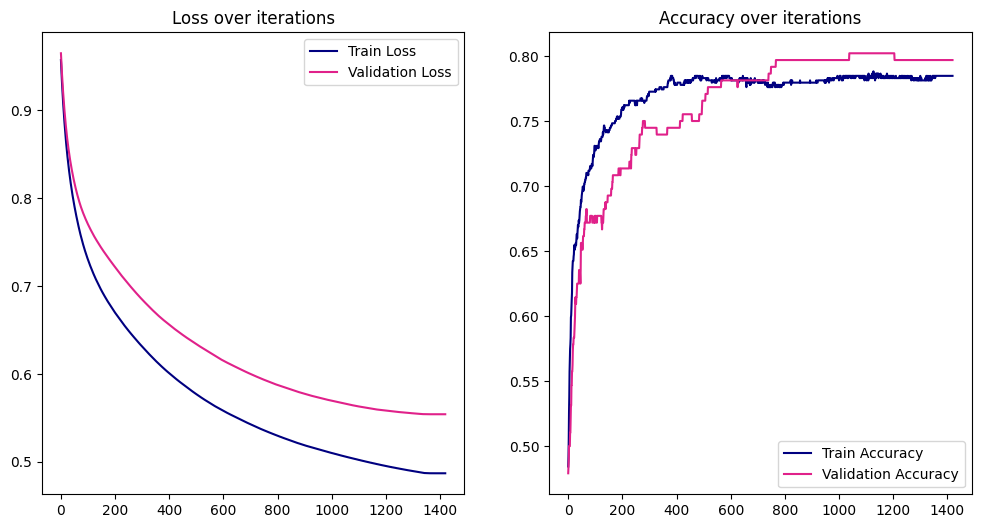

In [11]:
n = len(history.history["loss"])
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), history.history["loss"], color = '#000080', label="Train Loss")
ax.plot(range(n), history.history["val_loss"], color = '#E0218A', label="Validation Loss")
ax.legend()
ax.set_title("Loss over iterations")
ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), history.history["accuracy"], color = '#000080', label="Train Accuracy")
ax.plot(range(n), history.history["val_accuracy"], color = '#E0218A', label="Validation Accuracy")
ax.legend()
ax.set_title("Accuracy over iterations")
plt.show()

Lastly, we displays the final accuracy and ROC curve of the model on the test set. The ROC curve shows the model's classification performance, and the AUC value is used to measure the model's ability to distinguish between classes.

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

accuracy is 0.797
roc-auc is 0.821


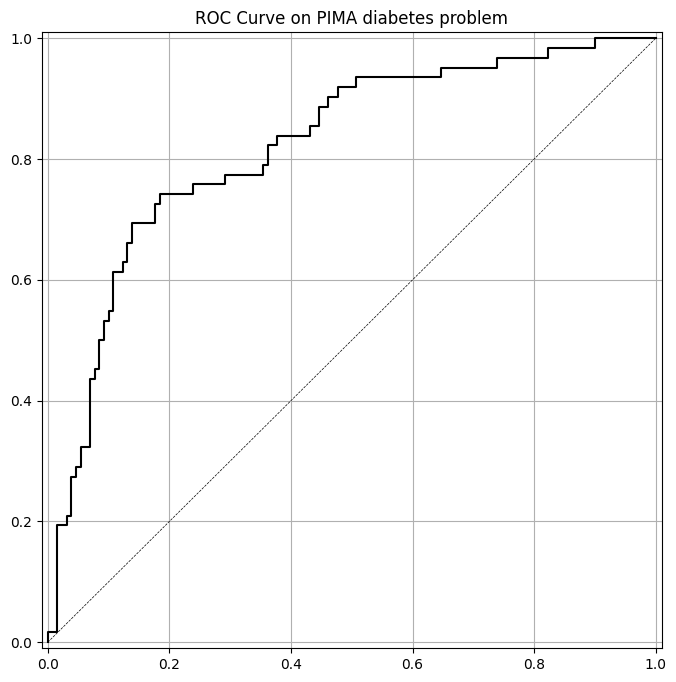

In [12]:
y_pred_prob = model.predict(X_test_norm)
y_pred_class = (y_pred_prob > 0.5).astype(int)
print("")
print("accuracy is {:.3f}".format(accuracy_score(y_test, y_pred_class)))
print("roc-auc is {:.3f}".format(roc_auc_score(y_test, y_pred_prob)))
def plot_roc(y_test, y_pred):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve on PIMA diabetes problem', xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])
plot_roc(y_test, y_pred_prob)